In [51]:
import numpy as np
import pandas as pd
import os
import h5py
import wandb

import string
import random

import torch 
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

import lightning as L
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint


from torch import optim, utils, Tensor

import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import sklearn.linear_model


from itables import show

Here, we had 3 different ways to evaluate when to stop based on validation performance (loss, f1, and error). We will look at the ROC curves between training and testing, and probably go with the one that shows the smallest difference in performance (not necessarily the best validation performance on its own). 

In [2]:


import os
os.environ['HTTP_PROXY']="http://www-int.dkfz-heidelberg.de:80"
os.environ['HTTPS_PROXY']="http://www-int.dkfz-heidelberg.de:80"


In [3]:

slide_annots = pd.read_csv("/omics/odcf/analysis/OE0585_projects/chromothripsis/histopathology/metadata/tcga_labeled_data.csv")


slide_annots.index = slide_annots.slide_id

In [6]:
slide_annots['labels'] = np.abs(1-slide_annots.CT_Status.factorize(sort=True)[0])

In [7]:

api = wandb.Api()


In [8]:
runs = api.runs(path="psmirnov/TCGA_RetCLL_299_CT", filters={"group": "4ZFF4Q"})

# Loss

First we try using the loss, which I think is the least likely to work well. 

In [9]:
train_preds = list()
train_labels = list()
train_probs = list()

valid_preds = list()
valid_labels = list()
valid_probs = list()

test_preds = list()
test_labels = list()
test_probs = list()

train_mean = list()
valid_mean = list()
test_mean = list()
    
train_combined = list()
valid_combined = list()
test_combined = list()


In [10]:
for ii in range(len(runs)):
    arts = runs[ii].logged_artifacts()
    arts_dict = {a.name.removesuffix(':'+a.version): a for a in arts}
    training_slides = arts_dict['fold'].get('training').get_dataframe()
    valid_slides = arts_dict['fold'].get('validation').get_dataframe()
    testing_slides = arts_dict['fold'].get('testing').get_dataframe()
    
    train_data = slide_annots.loc[training_slides[0]]
    valid_data = slide_annots.loc[valid_slides[0]]
    test_data = slide_annots.loc[testing_slides[0]]
    
    train_mean.append(pd.merge(train_data,train_data.groupby('project').labels.mean(), how='left', left_on='project',right_on='project').labels_y)
    valid_mean.append(pd.merge(valid_data,train_data.groupby('project').labels.mean(), how='left', left_on='project',right_on='project').labels_y)
    test_mean.append(pd.merge(test_data,train_data.groupby('project').labels.mean(), how='left', left_on='project',right_on='project').labels_y)
    
    train_labels.append(np.abs(1-train_data.CT_Status.factorize(sort=True)[0]))
    train_preds.append(arts_dict['preds_loss'].get('training').get_dataframe())
    train_probs.append(arts_dict['preds_loss'].get('training_probs').get_dataframe())

    valid_labels.append(np.abs(1-valid_data.CT_Status.factorize(sort=True)[0]))
    valid_preds.append(arts_dict['preds_loss'].get('validation').get_dataframe())
    valid_probs.append(arts_dict['preds_loss'].get('validation_probs').get_dataframe())
    
    test_labels.append(np.abs(1-test_data.CT_Status.factorize(sort=True)[0]))
    test_preds.append(arts_dict['preds_loss'].get('testing').get_dataframe())
    test_probs.append(arts_dict['preds_loss'].get('testing_probs').get_dataframe())
    
    logistic_model= sklearn.linear_model.LogisticRegression(penalty=None)

    X_train = np.stack([np.transpose(train_probs[ii][0]), np.array(train_mean[ii]).transpose()])
    X_valid = np.stack([np.transpose(valid_probs[ii][0]), np.array(valid_mean[ii]).transpose()])
    X_test = np.stack([np.transpose(test_probs[ii][0]), np.array(test_mean[ii]).transpose()])
     
    
    logistic_model.fit(X_train.transpose()[~np.isnan(train_mean[ii])], train_labels[ii][~np.isnan(train_mean[ii])])
    train_combined.append(logistic_model.predict_proba(X_train.transpose()[~np.isnan(train_mean[ii])]))
    valid_combined.append(logistic_model.predict_proba(X_valid.transpose()[~np.isnan(valid_mean[ii])]))
    test_combined.append(logistic_model.predict_proba(X_test.transpose()[~np.isnan(test_mean[ii])]))


wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   3 of 3 files downlo

In [11]:
train_mean = np.concatenate(train_mean)
valid_mean = np.concatenate(valid_mean)
test_mean = np.concatenate(test_mean)


In [12]:
train_combined = np.concatenate(train_combined)
valid_combined = np.concatenate(valid_combined)
test_combined = np.concatenate(test_combined)

In [13]:
len(np.concatenate(valid_preds))

3090

In [14]:
len(np.concatenate(test_preds))

3108

In [15]:
train_labels = np.concatenate(train_labels)
train_preds = np.concatenate(train_preds)
train_probs = np.concatenate(train_probs)


In [16]:
train_combined

array([[0.81771199, 0.18228801],
       [0.99681096, 0.00318904],
       [0.99333677, 0.00666323],
       ...,
       [0.15240441, 0.84759559],
       [0.1456566 , 0.8543434 ],
       [0.69110657, 0.30889343]])

## Train

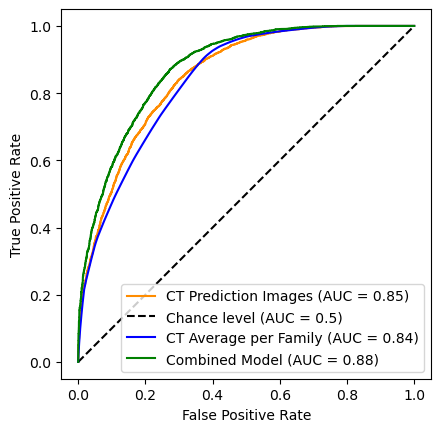

In [17]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    train_labels,
    train_probs,
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
RocCurveDisplay.from_predictions(
    train_labels[~np.isnan(train_mean)],
    train_mean[~np.isnan(train_mean)],
    name="CT Average per Family",
    color="blue",
    ax=ax,
)
RocCurveDisplay.from_predictions(
    train_labels[~np.isnan(train_mean)],
    # np.ones(preds_logistic.shape[0]),
    train_combined[:,1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

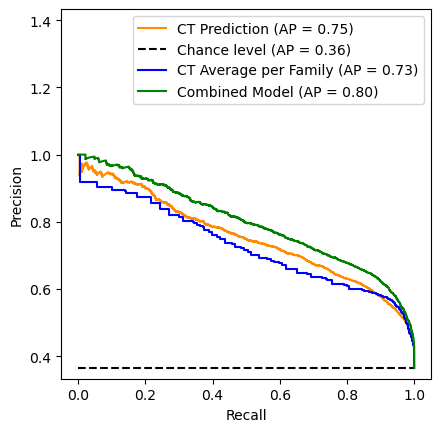

In [28]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(
    train_labels,
    train_probs,
    name="CT Prediction",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
PrecisionRecallDisplay.from_predictions(
    train_labels[~np.isnan(train_mean)],
    train_mean[~np.isnan(train_mean)],
    name="CT Average per Family",
    color="blue",
    ax=ax
)

PrecisionRecallDisplay.from_predictions(
    train_labels[~np.isnan(train_mean)],
    # np.ones(preds_logistic.shape[0]),
    train_combined[:,1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)

plt.axis("square")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("")
plt.legend()
plt.show()

## Valid

In [29]:
valid_labels = np.concatenate(valid_labels)
valid_preds = np.concatenate(valid_preds)
valid_probs = np.concatenate(valid_probs)

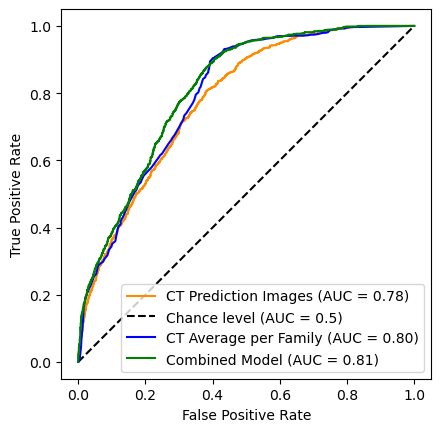

In [30]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    valid_labels,
    valid_probs,
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
RocCurveDisplay.from_predictions(
    valid_labels[~np.isnan(valid_mean)],
    valid_mean[~np.isnan(valid_mean)],
    name="CT Average per Family",
    color="blue",
    ax=ax,
)
RocCurveDisplay.from_predictions(
    valid_labels[~np.isnan(valid_mean)],
    # np.ones(preds_logistic.shape[0]),
    valid_combined[:,1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

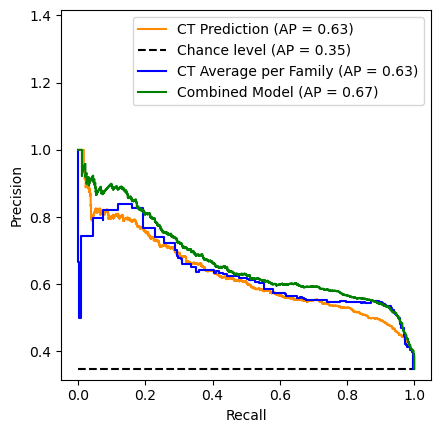

In [31]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(
    valid_labels,
    valid_probs,
    name="CT Prediction",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
PrecisionRecallDisplay.from_predictions(
    valid_labels[~np.isnan(valid_mean)],
    valid_mean[~np.isnan(valid_mean)],
    name="CT Average per Family",
    color="blue",
    ax=ax
)

PrecisionRecallDisplay.from_predictions(
    valid_labels[~np.isnan(valid_mean)],
    # np.ones(preds_logistic.shape[0]),
    valid_combined[:,1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)

plt.axis("square")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("")
plt.legend()
plt.show()

# Error

Now, we try the error as the measure for selecting the model

In [34]:
train_preds = list()
train_labels = list()
train_probs = list()

valid_preds = list()
valid_labels = list()
valid_probs = list()

test_preds = list()
test_labels = list()
test_probs = list()

train_mean = list()
valid_mean = list()
test_mean = list()
    
train_combined = list()
valid_combined = list()
test_combined = list()


In [35]:
for ii in range(len(runs)):
    arts = runs[ii].logged_artifacts()
    arts_dict = {a.name.removesuffix(':'+a.version): a for a in arts}
    training_slides = arts_dict['fold'].get('training').get_dataframe()
    valid_slides = arts_dict['fold'].get('validation').get_dataframe()
    testing_slides = arts_dict['fold'].get('testing').get_dataframe()
    
    train_data = slide_annots.loc[training_slides[0]]
    valid_data = slide_annots.loc[valid_slides[0]]
    test_data = slide_annots.loc[testing_slides[0]]
    
    train_mean.append(pd.merge(train_data,train_data.groupby('project').labels.mean(), how='left', left_on='project',right_on='project').labels_y)
    valid_mean.append(pd.merge(valid_data,train_data.groupby('project').labels.mean(), how='left', left_on='project',right_on='project').labels_y)
    test_mean.append(pd.merge(test_data,train_data.groupby('project').labels.mean(), how='left', left_on='project',right_on='project').labels_y)
    
    train_labels.append(np.abs(1-train_data.CT_Status.factorize(sort=True)[0]))
    train_preds.append(arts_dict['preds_error'].get('training').get_dataframe())
    train_probs.append(arts_dict['preds_error'].get('training_probs').get_dataframe())

    valid_labels.append(np.abs(1-valid_data.CT_Status.factorize(sort=True)[0]))
    valid_preds.append(arts_dict['preds_error'].get('validation').get_dataframe())
    valid_probs.append(arts_dict['preds_error'].get('validation_probs').get_dataframe())
    
    test_labels.append(np.abs(1-test_data.CT_Status.factorize(sort=True)[0]))
    test_preds.append(arts_dict['preds_error'].get('testing').get_dataframe())
    test_probs.append(arts_dict['preds_error'].get('testing_probs').get_dataframe())
    
    logistic_model= sklearn.linear_model.LogisticRegression(penalty=None)

    X_train = np.stack([np.transpose(train_probs[ii][0]), np.array(train_mean[ii]).transpose()])
    X_valid = np.stack([np.transpose(valid_probs[ii][0]), np.array(valid_mean[ii]).transpose()])
    X_test = np.stack([np.transpose(test_probs[ii][0]), np.array(test_mean[ii]).transpose()])
     
    
    logistic_model.fit(X_train.transpose()[~np.isnan(train_mean[ii])], train_labels[ii][~np.isnan(train_mean[ii])])
    train_combined.append(logistic_model.predict_proba(X_train.transpose()[~np.isnan(train_mean[ii])]))
    valid_combined.append(logistic_model.predict_proba(X_valid.transpose()[~np.isnan(valid_mean[ii])]))
    test_combined.append(logistic_model.predict_proba(X_test.transpose()[~np.isnan(test_mean[ii])]))


wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   3 of 3 files downlo

In [36]:
train_mean = np.concatenate(train_mean)
valid_mean = np.concatenate(valid_mean)
test_mean = np.concatenate(test_mean)


In [37]:
train_combined = np.concatenate(train_combined)
valid_combined = np.concatenate(valid_combined)
test_combined = np.concatenate(test_combined)

In [38]:
len(np.concatenate(valid_preds))

3090

In [39]:
len(np.concatenate(test_preds))

3108

In [40]:
train_labels = np.concatenate(train_labels)
train_preds = np.concatenate(train_preds)
train_probs = np.concatenate(train_probs)


In [41]:
train_combined

array([[9.89134377e-01, 1.08656232e-02],
       [1.00000000e+00, 4.37416399e-14],
       [9.99999587e-01, 4.12851446e-07],
       ...,
       [3.65838484e-05, 9.99963416e-01],
       [3.72104712e-05, 9.99962790e-01],
       [8.60866142e-04, 9.99139134e-01]])

## Train

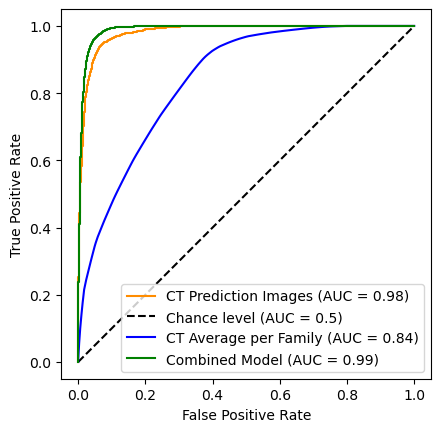

In [42]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    train_labels,
    train_probs,
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
RocCurveDisplay.from_predictions(
    train_labels[~np.isnan(train_mean)],
    train_mean[~np.isnan(train_mean)],
    name="CT Average per Family",
    color="blue",
    ax=ax,
)
RocCurveDisplay.from_predictions(
    train_labels[~np.isnan(train_mean)],
    # np.ones(preds_logistic.shape[0]),
    train_combined[:,1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

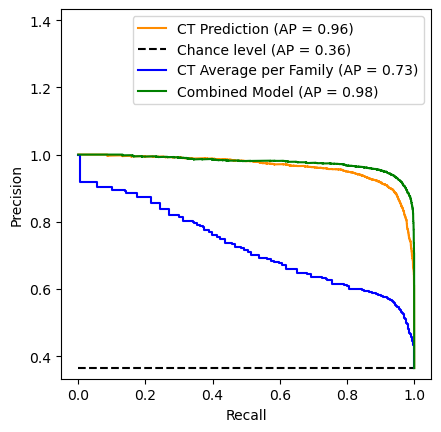

In [43]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(
    train_labels,
    train_probs,
    name="CT Prediction",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
PrecisionRecallDisplay.from_predictions(
    train_labels[~np.isnan(train_mean)],
    train_mean[~np.isnan(train_mean)],
    name="CT Average per Family",
    color="blue",
    ax=ax
)

PrecisionRecallDisplay.from_predictions(
    train_labels[~np.isnan(train_mean)],
    # np.ones(preds_logistic.shape[0]),
    train_combined[:,1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)

plt.axis("square")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("")
plt.legend()
plt.show()

## Valid

In [44]:
valid_labels = np.concatenate(valid_labels)
valid_preds = np.concatenate(valid_preds)
valid_probs = np.concatenate(valid_probs)

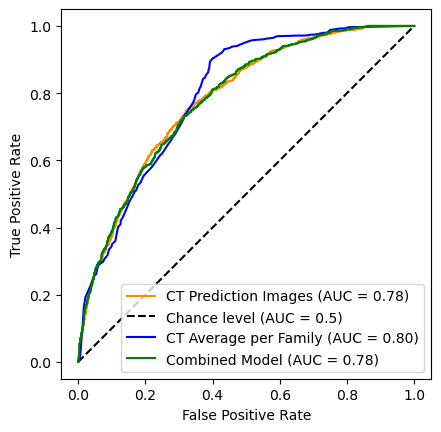

In [45]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    valid_labels,
    valid_probs,
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
RocCurveDisplay.from_predictions(
    valid_labels[~np.isnan(valid_mean)],
    valid_mean[~np.isnan(valid_mean)],
    name="CT Average per Family",
    color="blue",
    ax=ax,
)
RocCurveDisplay.from_predictions(
    valid_labels[~np.isnan(valid_mean)],
    # np.ones(preds_logistic.shape[0]),
    valid_combined[:,1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

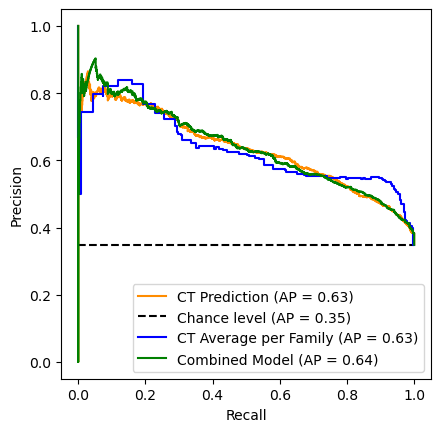

In [46]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(
    valid_labels,
    valid_probs,
    name="CT Prediction",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
PrecisionRecallDisplay.from_predictions(
    valid_labels[~np.isnan(valid_mean)],
    valid_mean[~np.isnan(valid_mean)],
    name="CT Average per Family",
    color="blue",
    ax=ax
)

PrecisionRecallDisplay.from_predictions(
    valid_labels[~np.isnan(valid_mean)],
    # np.ones(preds_logistic.shape[0]),
    valid_combined[:,1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)

plt.axis("square")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("")
plt.legend()
plt.show()

# F1

Finally, the F1 score

In [49]:
train_preds = list()
train_labels = list()
train_probs = list()

valid_preds = list()
valid_labels = list()
valid_probs = list()

test_preds = list()
test_labels = list()
test_probs = list()

train_mean = list()
valid_mean = list()
test_mean = list()
    
train_combined = list()
valid_combined = list()
test_combined = list()


In [50]:
for ii in range(len(runs)):
    arts = runs[ii].logged_artifacts()
    arts_dict = {a.name.removesuffix(':'+a.version): a for a in arts}
    training_slides = arts_dict['fold'].get('training').get_dataframe()
    valid_slides = arts_dict['fold'].get('validation').get_dataframe()
    testing_slides = arts_dict['fold'].get('testing').get_dataframe()
    
    train_data = slide_annots.loc[training_slides[0]]
    valid_data = slide_annots.loc[valid_slides[0]]
    test_data = slide_annots.loc[testing_slides[0]]
    
    train_mean.append(pd.merge(train_data,train_data.groupby('project').labels.mean(), how='left', left_on='project',right_on='project').labels_y)
    valid_mean.append(pd.merge(valid_data,train_data.groupby('project').labels.mean(), how='left', left_on='project',right_on='project').labels_y)
    test_mean.append(pd.merge(test_data,train_data.groupby('project').labels.mean(), how='left', left_on='project',right_on='project').labels_y)
    
    train_labels.append(np.abs(1-train_data.CT_Status.factorize(sort=True)[0]))
    train_preds.append(arts_dict['preds_f1'].get('training').get_dataframe())
    train_probs.append(arts_dict['preds_f1'].get('training_probs').get_dataframe())

    valid_labels.append(np.abs(1-valid_data.CT_Status.factorize(sort=True)[0]))
    valid_preds.append(arts_dict['preds_f1'].get('validation').get_dataframe())
    valid_probs.append(arts_dict['preds_f1'].get('validation_probs').get_dataframe())
    
    test_labels.append(np.abs(1-test_data.CT_Status.factorize(sort=True)[0]))
    test_preds.append(arts_dict['preds_f1'].get('testing').get_dataframe())
    test_probs.append(arts_dict['preds_f1'].get('testing_probs').get_dataframe())
    
    logistic_model= sklearn.linear_model.LogisticRegression(penalty=None)

    X_train = np.stack([np.transpose(train_probs[ii][0]), np.array(train_mean[ii]).transpose()])
    X_valid = np.stack([np.transpose(valid_probs[ii][0]), np.array(valid_mean[ii]).transpose()])
    X_test = np.stack([np.transpose(test_probs[ii][0]), np.array(test_mean[ii]).transpose()])
     
    
    logistic_model.fit(X_train.transpose()[~np.isnan(train_mean[ii])], train_labels[ii][~np.isnan(train_mean[ii])])
    train_combined.append(logistic_model.predict_proba(X_train.transpose()[~np.isnan(train_mean[ii])]))
    valid_combined.append(logistic_model.predict_proba(X_valid.transpose()[~np.isnan(valid_mean[ii])]))
    test_combined.append(logistic_model.predict_proba(X_test.transpose()[~np.isnan(test_mean[ii])]))


wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   3 of 3 files downlo

In [51]:
train_mean = np.concatenate(train_mean)
valid_mean = np.concatenate(valid_mean)
test_mean = np.concatenate(test_mean)


In [52]:
train_combined = np.concatenate(train_combined)
valid_combined = np.concatenate(valid_combined)
test_combined = np.concatenate(test_combined)

In [53]:
len(np.concatenate(valid_preds))

3090

In [54]:
len(np.concatenate(test_preds))

3108

In [55]:
train_labels = np.concatenate(train_labels)
train_preds = np.concatenate(train_preds)
train_probs = np.concatenate(train_probs)


In [56]:
train_combined

array([[9.93953199e-01, 6.04680116e-03],
       [1.00000000e+00, 3.50260782e-17],
       [9.99999985e-01, 1.48079413e-08],
       ...,
       [1.47523333e-06, 9.99998525e-01],
       [1.95413206e-06, 9.99998046e-01],
       [3.88264988e-05, 9.99961174e-01]])

## Train

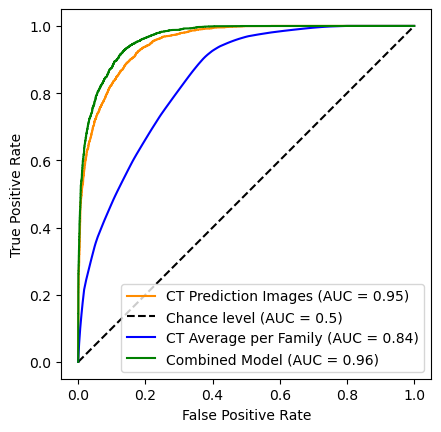

In [57]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    train_labels,
    train_probs,
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
RocCurveDisplay.from_predictions(
    train_labels[~np.isnan(train_mean)],
    train_mean[~np.isnan(train_mean)],
    name="CT Average per Family",
    color="blue",
    ax=ax,
)
RocCurveDisplay.from_predictions(
    train_labels[~np.isnan(train_mean)],
    # np.ones(preds_logistic.shape[0]),
    train_combined[:,1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

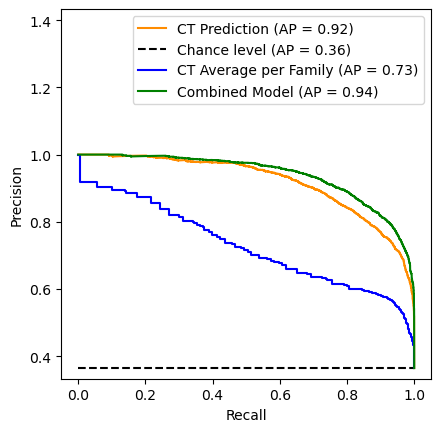

In [58]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(
    train_labels,
    train_probs,
    name="CT Prediction",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
PrecisionRecallDisplay.from_predictions(
    train_labels[~np.isnan(train_mean)],
    train_mean[~np.isnan(train_mean)],
    name="CT Average per Family",
    color="blue",
    ax=ax
)

PrecisionRecallDisplay.from_predictions(
    train_labels[~np.isnan(train_mean)],
    # np.ones(preds_logistic.shape[0]),
    train_combined[:,1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)

plt.axis("square")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("")
plt.legend()
plt.show()

## Valid

In [59]:
valid_labels = np.concatenate(valid_labels)
valid_preds = np.concatenate(valid_preds)
valid_probs = np.concatenate(valid_probs)

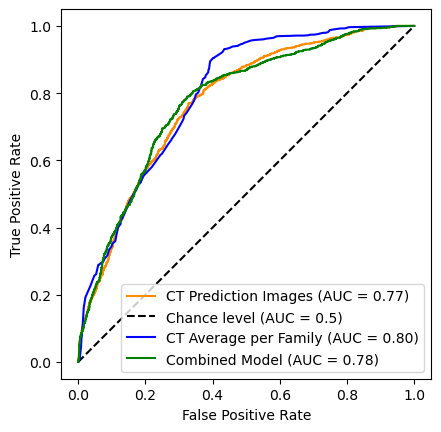

In [60]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    valid_labels,
    valid_probs,
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
RocCurveDisplay.from_predictions(
    valid_labels[~np.isnan(valid_mean)],
    valid_mean[~np.isnan(valid_mean)],
    name="CT Average per Family",
    color="blue",
    ax=ax,
)
RocCurveDisplay.from_predictions(
    valid_labels[~np.isnan(valid_mean)],
    # np.ones(preds_logistic.shape[0]),
    valid_combined[:,1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

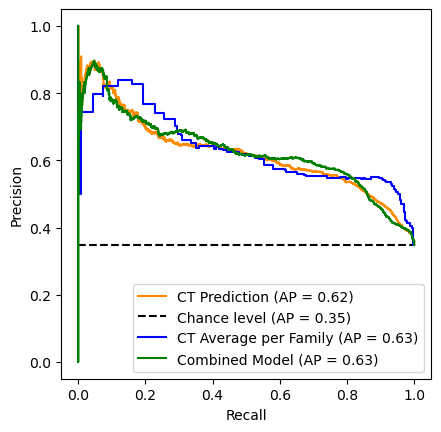

In [61]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(
    valid_labels,
    valid_probs,
    name="CT Prediction",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
PrecisionRecallDisplay.from_predictions(
    valid_labels[~np.isnan(valid_mean)],
    valid_mean[~np.isnan(valid_mean)],
    name="CT Average per Family",
    color="blue",
    ax=ax
)

PrecisionRecallDisplay.from_predictions(
    valid_labels[~np.isnan(valid_mean)],
    # np.ones(preds_logistic.shape[0]),
    valid_combined[:,1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)

plt.axis("square")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("")
plt.legend()
plt.show()

# Summary

The results are as follows:

| Stopping Method | Score | Train | Valid| Difference| 
| --- | --- | --- |  --- |  --- | 
| Loss | AUROC | 95 | 91 | 4|
| Loss | AUPR | 87 | 81 | 6 |
| Error | AUROC | 99 | 86 | 13 |
| Error | AUPR | 98 | 73 | 25 |
| F1 | AUROC | 99 | 88 | 11 |
| F1 | AUPR | 96 | 74 | 22 |

Loss seems to perform best both numerically and by the gap, so we reload it and evaluate the testing performance

## Reload loss

In [18]:
train_preds = list()
train_labels = list()
train_probs = list()

valid_preds = list()
valid_labels = list()
valid_probs = list()

test_preds = list()
test_labels = list()
test_probs = list()

train_mean = list()
valid_mean = list()
test_mean = list()
    
train_combined = list()
valid_combined = list()
test_combined = list()


train_family = list()
valid_family = list()
test_family = list()


train_superfamily = list()
valid_superfamily = list()
test_superfamily = list()


In [19]:
for ii in range(len(runs)):
    arts = runs[ii].logged_artifacts()
    arts_dict = {a.name.removesuffix(':'+a.version): a for a in arts}
    training_slides = arts_dict['fold'].get('training').get_dataframe()
    valid_slides = arts_dict['fold'].get('validation').get_dataframe()
    testing_slides = arts_dict['fold'].get('testing').get_dataframe()
    
    train_data = slide_annots.loc[training_slides[0]]
    valid_data = slide_annots.loc[valid_slides[0]]
    test_data = slide_annots.loc[testing_slides[0]]
    
    train_family.append(np.array(train_data.project))
    valid_family.append(np.array(valid_data.project))
    test_family.append(np.array(test_data.project))
    
    # train_superfamily.append(np.array(train_data.max_super_family_class))
    # valid_superfamily.append(np.array(valid_data.max_super_family_class))
    # test_superfamily.append(np.array(test_data.max_super_family_class))
    
    train_mean.append(pd.merge(train_data,train_data.groupby('project').labels.mean(), how='left', left_on='project',right_on='project').labels_y)
    valid_mean.append(pd.merge(valid_data,train_data.groupby('project').labels.mean(), how='left', left_on='project',right_on='project').labels_y)
    test_mean.append(pd.merge(test_data,train_data.groupby('project').labels.mean(), how='left', left_on='project',right_on='project').labels_y)
    
    train_labels.append(np.abs(1-train_data.CT_Status.factorize(sort=True)[0]))
    train_preds.append(arts_dict['preds_loss'].get('training').get_dataframe())
    train_probs.append(arts_dict['preds_loss'].get('training_probs').get_dataframe())

    valid_labels.append(np.abs(1-valid_data.CT_Status.factorize(sort=True)[0]))
    valid_preds.append(arts_dict['preds_loss'].get('validation').get_dataframe())
    valid_probs.append(arts_dict['preds_loss'].get('validation_probs').get_dataframe())
    
    test_labels.append(np.abs(1-test_data.CT_Status.factorize(sort=True)[0]))
    test_preds.append(arts_dict['preds_loss'].get('testing').get_dataframe())
    test_probs.append(arts_dict['preds_loss'].get('testing_probs').get_dataframe())
    
    logistic_model= sklearn.linear_model.LogisticRegression(penalty=None)

    X_train = np.stack([np.transpose(train_probs[ii][0]), np.array(train_mean[ii]).transpose()])
    X_valid = np.stack([np.transpose(valid_probs[ii][0]), np.array(valid_mean[ii]).transpose()])
    X_test = np.stack([np.transpose(test_probs[ii][0]), np.array(test_mean[ii]).transpose()])
     
    
    logistic_model.fit(X_train.transpose()[~np.isnan(train_mean[ii])], train_labels[ii][~np.isnan(train_mean[ii])])
    train_combined.append(logistic_model.predict_proba(X_train.transpose()[~np.isnan(train_mean[ii])]))
    valid_combined.append(logistic_model.predict_proba(X_valid.transpose()[~np.isnan(valid_mean[ii])]))
    test_combined.append(logistic_model.predict_proba(X_test.transpose()[~np.isnan(test_mean[ii])]))


wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   3 of 3 files downlo

In [20]:
train_family = np.concatenate(train_family)
valid_family = np.concatenate(valid_family)
test_family = np.concatenate(test_family)


In [21]:
train_mean = np.concatenate(train_mean)
valid_mean = np.concatenate(valid_mean)
test_mean = np.concatenate(test_mean)


In [22]:
train_combined = np.concatenate(train_combined)
valid_combined = np.concatenate(valid_combined)
test_combined = np.concatenate(test_combined)

In [44]:
valid_labels = np.concatenate(valid_labels)
valid_preds = np.concatenate(valid_preds)
valid_probs = np.concatenate(valid_probs)


In [45]:
test_labels = np.concatenate(test_labels)
test_preds = np.concatenate(test_preds)
test_probs = np.concatenate(test_probs)


ValueError: zero-dimensional arrays cannot be concatenated

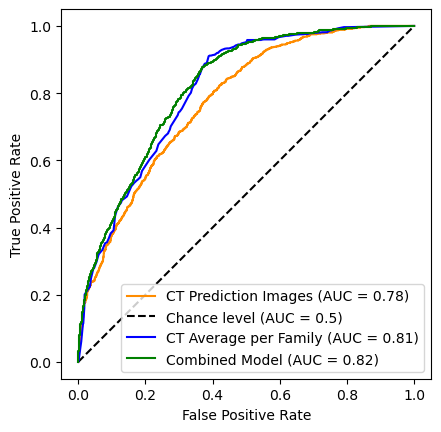

In [46]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    test_labels,
    test_probs,
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
RocCurveDisplay.from_predictions(
    test_labels[~np.isnan(test_mean)],
    test_mean[~np.isnan(test_mean)],
    name="CT Average per Family",
    color="blue",
    ax=ax,
)
RocCurveDisplay.from_predictions(
    test_labels[~np.isnan(test_mean)],
    # np.ones(preds_logistic.shape[0]),
    test_combined[:,1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

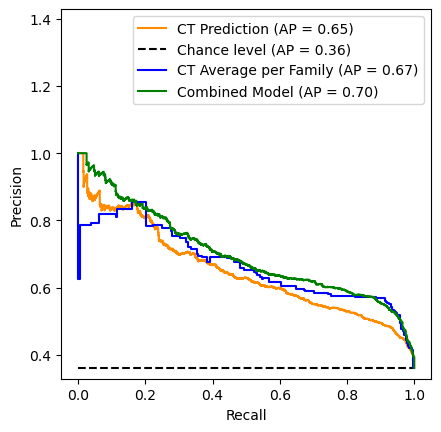

In [25]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(
    test_labels,
    test_probs,
    name="CT Prediction",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
PrecisionRecallDisplay.from_predictions(
    test_labels[~np.isnan(test_mean)],
    test_mean[~np.isnan(test_mean)],
    name="CT Average per Family",
    color="blue",
    ax=ax
)

PrecisionRecallDisplay.from_predictions(
    test_labels[~np.isnan(test_mean)],
    # np.ones(preds_logistic.shape[0]),
    test_combined[:,1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)

plt.axis("square")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("")
plt.legend()
plt.show()

# Lets look into subgroup analysis

In [52]:
families = np.unique(test_family)

In [27]:
test_family=='GBM'

array([False, False, False, ..., False, False, False])

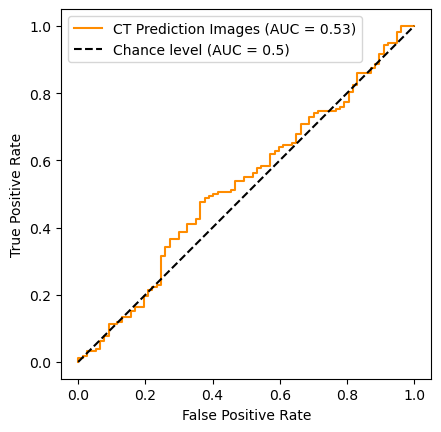

In [30]:
glioblasoma_indices = test_family=="GBM"


fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    test_labels[glioblasoma_indices],
    test_probs[glioblasoma_indices],
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

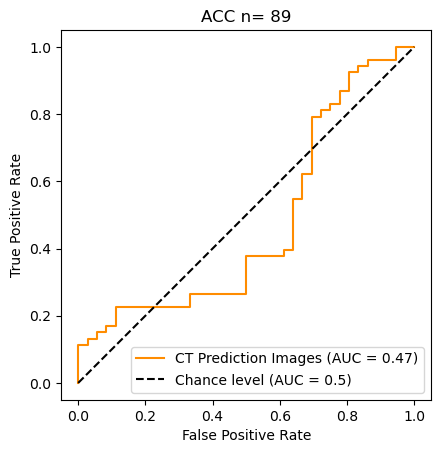

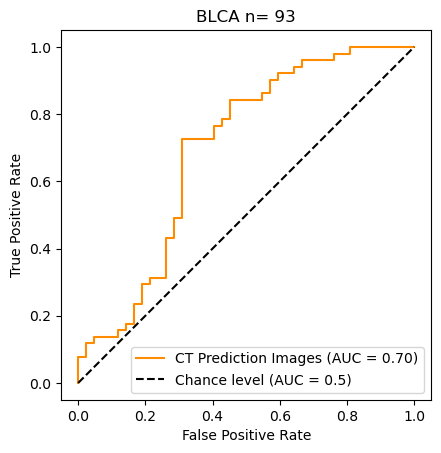

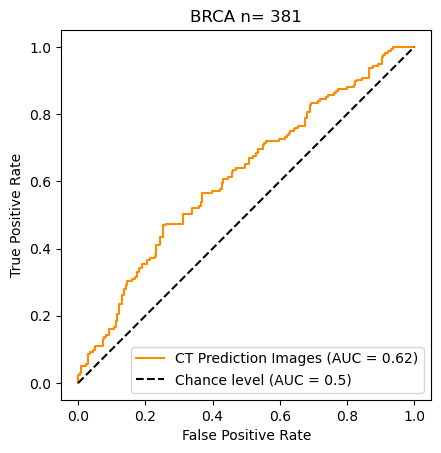

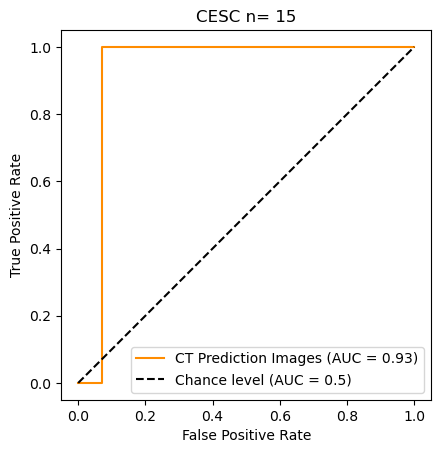

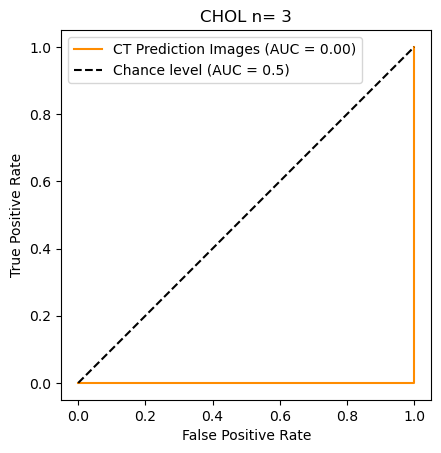

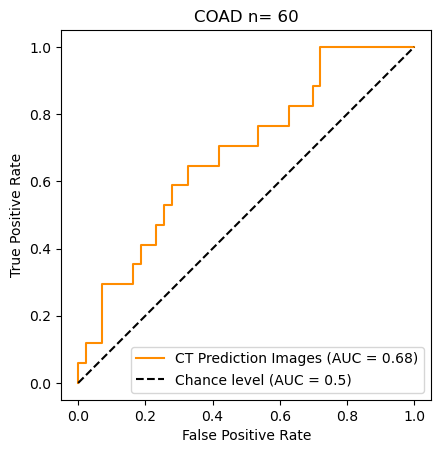

/home/p163v/mambaforge/envs/marugoto/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


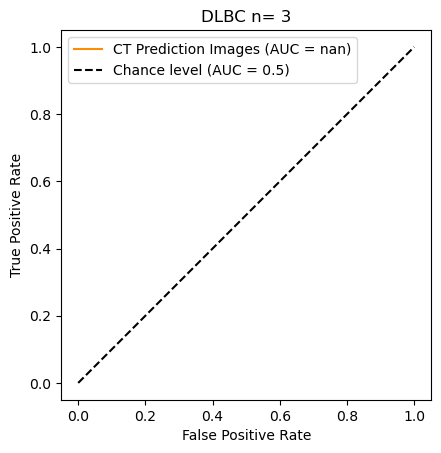

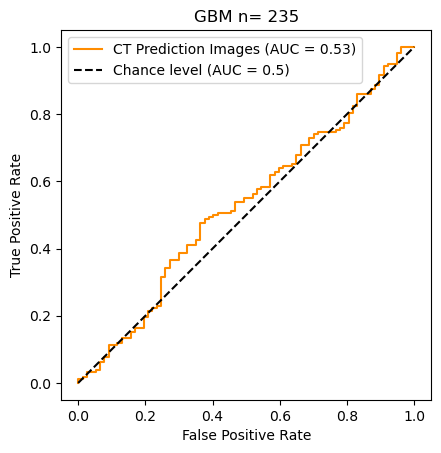

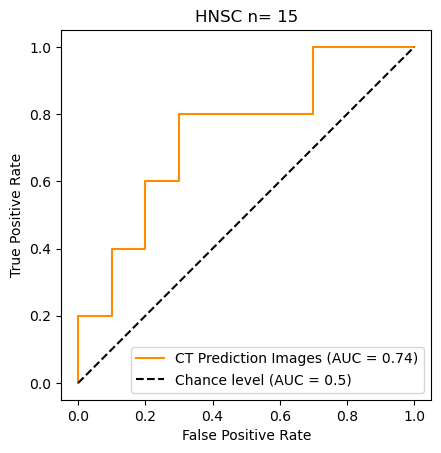

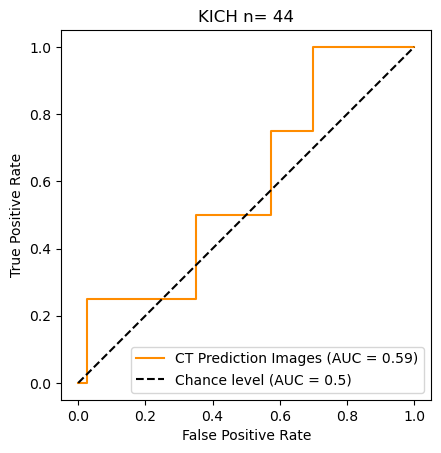

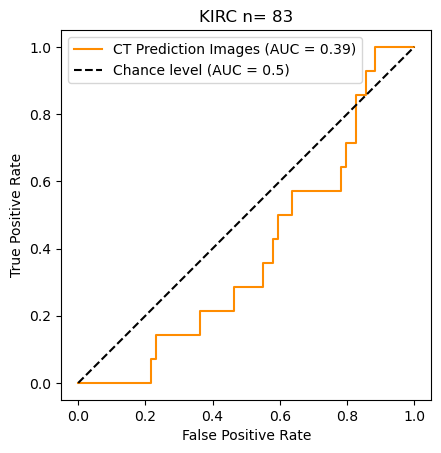

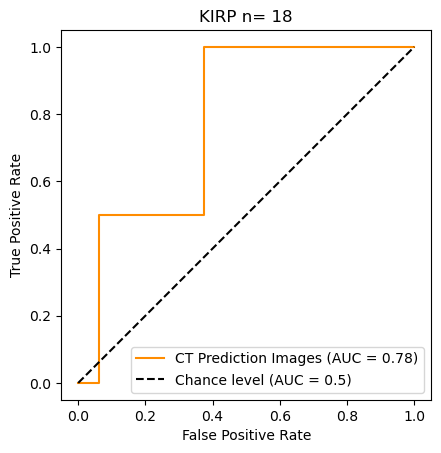

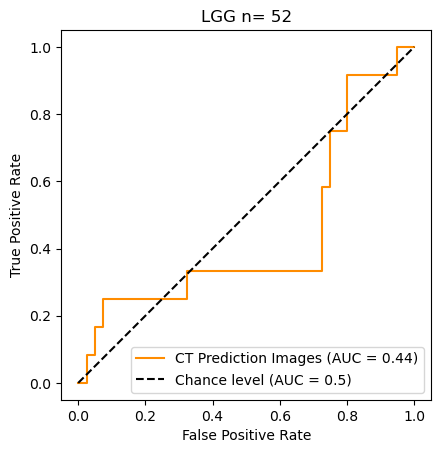

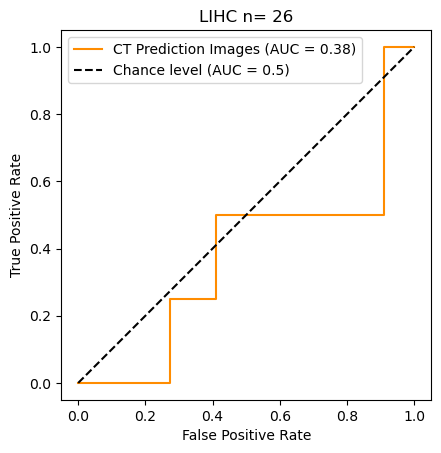

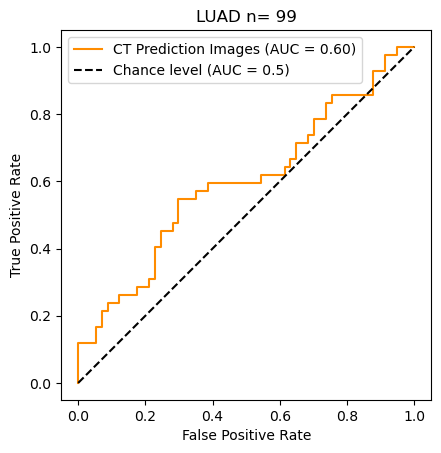

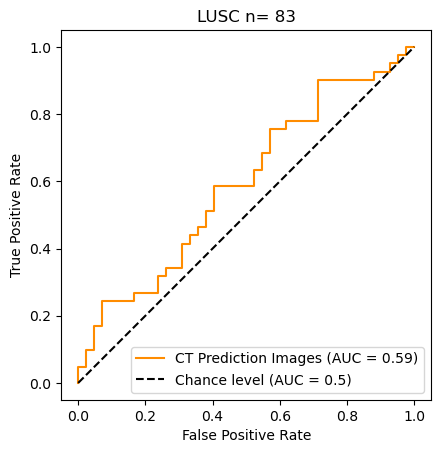

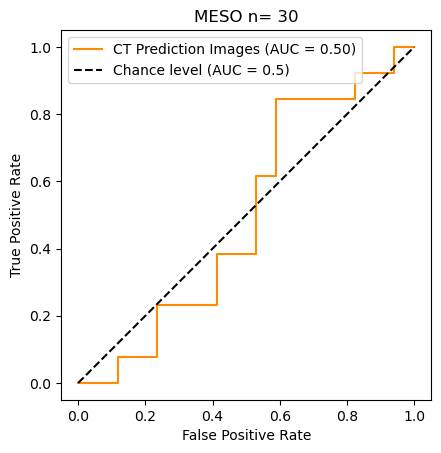

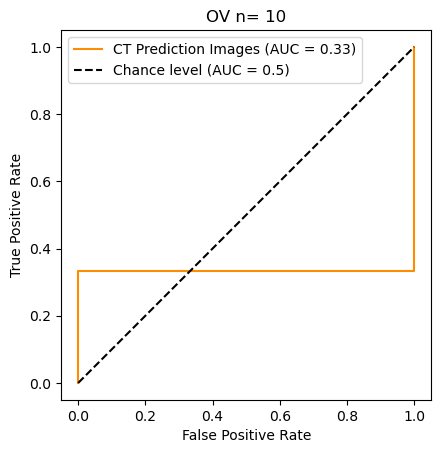

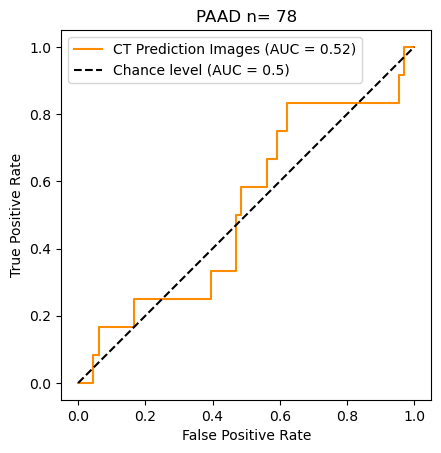

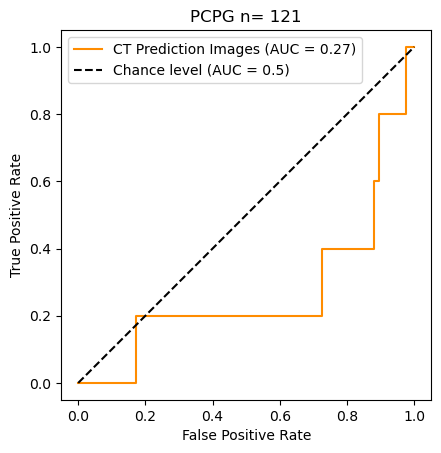

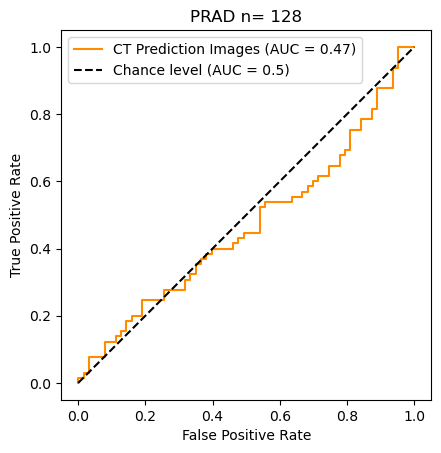

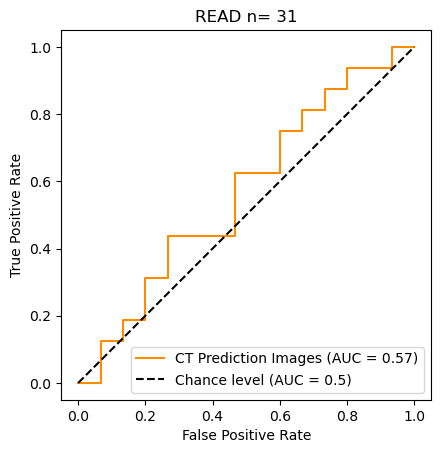

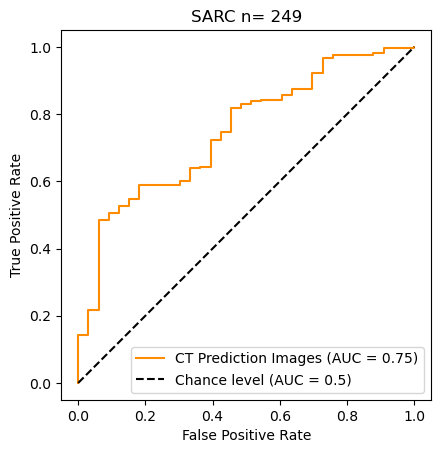

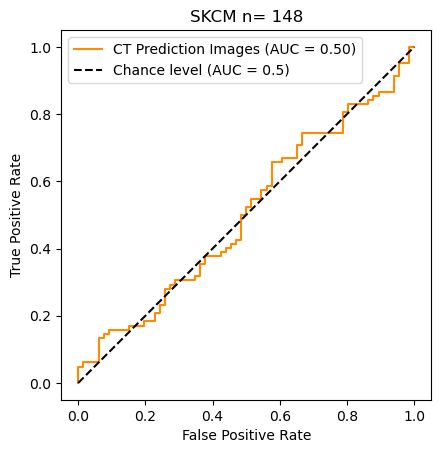

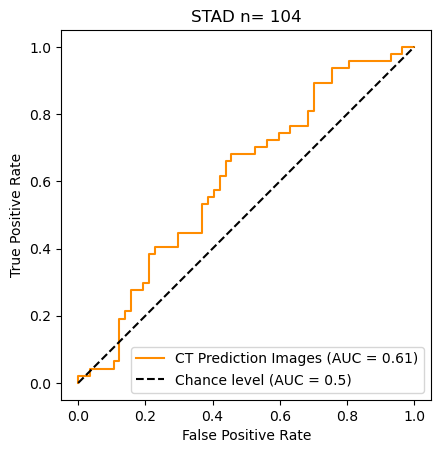

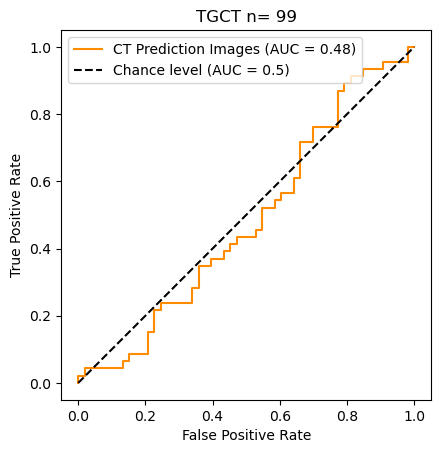

/home/p163v/mambaforge/envs/marugoto/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


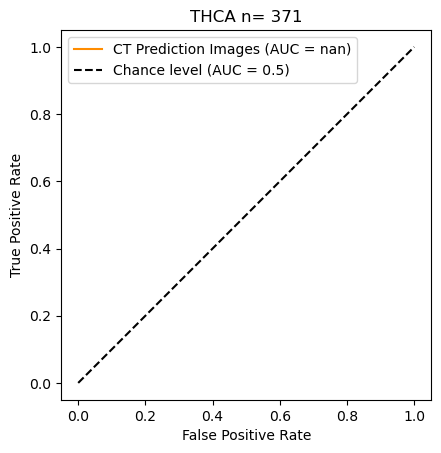

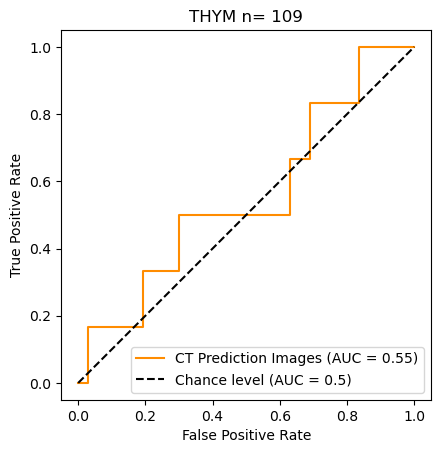

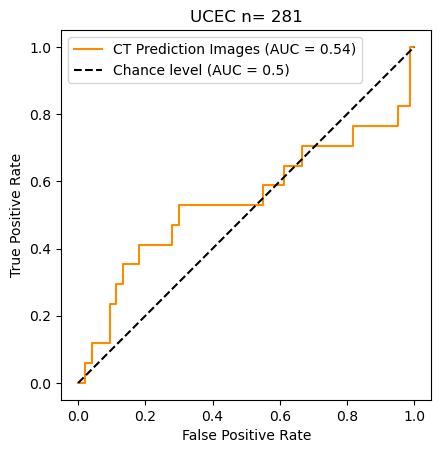

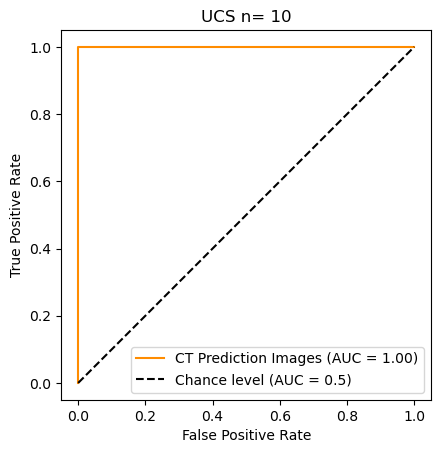

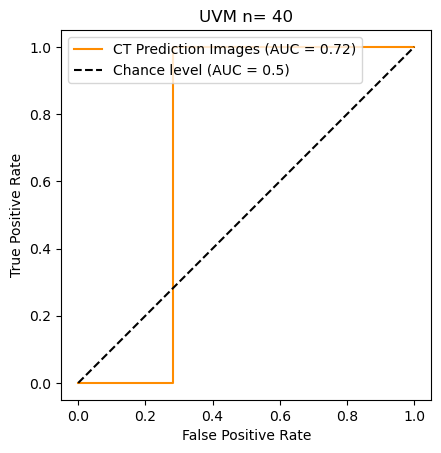

In [59]:
for fam in families:
    fam_indices = test_family==fam


    fig, ax = plt.subplots()
    RocCurveDisplay.from_predictions(
        test_labels[fam_indices],
        test_probs[fam_indices],
        name="CT Prediction Images",
        color="darkorange",
        plot_chance_level=True,
        ax=ax
    )
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(fam + " n= " + str(np.sum(fam_indices)))
    plt.legend()
    plt.show()

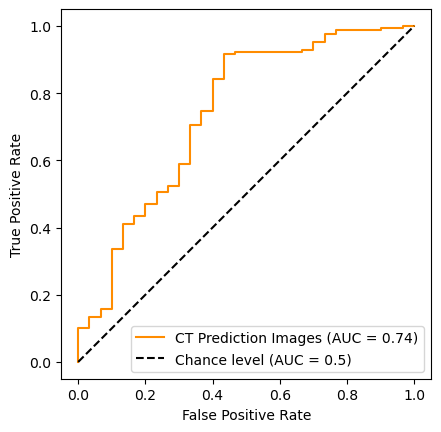

In [47]:
sarc_indices = valid_family=="SARC"


fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    valid_labels[sarc_indices],
    valid_probs[sarc_indices],
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

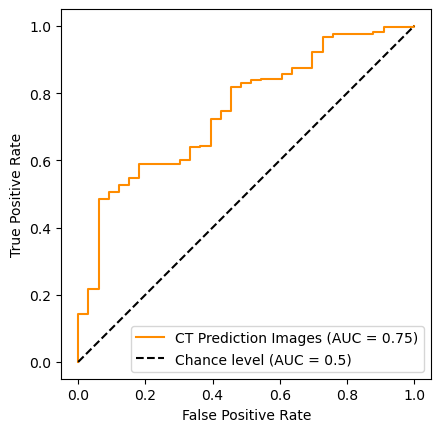

In [48]:
sarc_indices = test_family=="SARC"


fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    test_labels[sarc_indices],
    test_probs[sarc_indices],
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

In [50]:
sum(sarc_indices)

249

In [ ]:
slide_annots